In [ ]:
import subprocess
import torch
import numpy as np
from scipy.sparse import lil_matrix

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn

import torch.optim as optim
from sklearn.model_selection import train_test_split
from Tools.evalute_model import evaluate_metrics

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [19]:
train_x_file_path='Parabel/dataset/train_feat.txt'
train_y_file_path='Parabel/dataset/train_label.txt'

test_x_file_path='Parabel/dataset/test_feat.txt'
test_y_file_path='Parabel/dataset/test_label.txt'

model_dir='Parabel/output'
pred_y_file_path='Parabel/output/output_scores.txt'


pred_train_y_file_path='Parabel/output/train_output_scores.txt'
base_pred_y_adv_file_path='Parabel/output_adv/base_output_adv_scores.txt'


# training data with adv
adv_train_x_file_path='Parabel/dataset/adv_train_feat.txt'
adv_train_y_file_path='Parabel/dataset/adv_train_label.txt'
model_adv_dir='Parabel/output_adv'



# testing data with adv
adv_test_x_file_path='Parabel/dataset/adv_test_feat.txt'
adv_test_y_file_path='Parabel/dataset/adv_test_label.txt'

base_pred_y_adv_file_path='Parabel/output_adv/base_output_adv_scores.txt'
pred_y_adv_file_path='Parabel/output_adv/output_adv_scores.txt'


# Training Surrogate Model

In [3]:
def load_parabel_sparse_matrix(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    n_rows, n_cols = map(int, lines[0].strip().split())
    mat = lil_matrix((n_rows, n_cols), dtype=np.float32)

    for i, line in enumerate(lines[1:]):
        entries = line.strip().split()
        for entry in entries:
            index, value = entry.split(':')
            mat[i, int(index)] = float(value)

    return mat.tocsr()  # compressed format for fast row slicing


class SparseDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y=None):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx].toarray(), dtype=torch.float32).squeeze(0)
        if self.Y is not None:
            y = torch.tensor(self.Y[idx].toarray(), dtype=torch.float32).squeeze(0)
        else:
            y = torch.tensor([])  # return an empty tensor or None
        return x, y


In [4]:
X_sparse = load_parabel_sparse_matrix(train_x_file_path)
Y_sparse = load_parabel_sparse_matrix(pred_train_y_file_path)

train_dataset = SparseDataset(X_sparse, Y_sparse)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [5]:
print(X_sparse.shape)
print(Y_sparse.shape)

(15539, 5000)
(15539, 3993)


In [6]:
class SurrogateModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SurrogateModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.output = nn.Linear(512, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.output(x)
        return x


In [26]:
from torchsummary import summary
model = SurrogateModel(5000, 3993).to(device)

summary(model, (5000,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       5,121,024
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
       BatchNorm1d-6                  [-1, 512]           1,024
              ReLU-7                  [-1, 512]               0
           Dropout-8                  [-1, 512]               0
            Linear-9                 [-1, 3993]       2,048,409
Total params: 7,697,305
Trainable params: 7,697,305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.08
Params size (MB): 29.36
Estimated Total Size (MB): 29.46
-------------------------------------

In [7]:
input_dim = X_sparse.shape[1]
output_dim = Y_sparse.shape[1]
model = SurrogateModel(input_dim, output_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


Epoch 1/15 - Loss: 0.0693
Epoch 2/15 - Loss: 0.0088
Epoch 3/15 - Loss: 0.0081
Epoch 4/15 - Loss: 0.0077
Epoch 5/15 - Loss: 0.0076
Epoch 6/15 - Loss: 0.0074
Epoch 7/15 - Loss: 0.0073
Epoch 8/15 - Loss: 0.0071
Epoch 9/15 - Loss: 0.0069
Epoch 10/15 - Loss: 0.0068
Epoch 11/15 - Loss: 0.0065
Epoch 12/15 - Loss: 0.0062
Epoch 13/15 - Loss: 0.0060
Epoch 14/15 - Loss: 0.0059
Epoch 15/15 - Loss: 0.0057


In [8]:
torch.save(model.state_dict(), "surrogate_model.pth")

In [10]:
model.load_state_dict(torch.load("surrogate_model.pth"))

model.to(device)
model.eval()

SurrogateModel(
  (fc1): Linear(in_features=5000, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=512, out_features=3993, bias=True)
)

In [17]:
def fgsm_attack(model, X_batch, y_batch, epsilon=0.1):
    X_batch.requires_grad = True
    output = model(X_batch)

    loss = criterion(output, y_batch)

    # Compute the gradients
    model.zero_grad()
    loss.backward()

    # Get the sign of the gradients
    sign_data_grad = X_batch.grad.data.sign()

    # Perturb the input data
    perturbed_data = X_batch + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Clip values to [0, 1] range if needed

    return perturbed_data



def convert_to_parabel_format(X_dense, Y_dense):
    # Initialize the list to store the data in Parabel format
    X_parabel_format = []
    Y_parabel_format = []

    print(X_dense.shape)
    print(Y_dense.shape)

    # Iterate through each sample in the dataset
    for i in range(X_dense.shape[0]):
        # Get the non-zero entries for the sample (X_dense[i])
        non_zero_entries = []
        for j in range(X_dense.shape[1]):
            if X_dense[i, j] != 0:
                non_zero_entries.append(f"{j}:{X_dense[i, j]}")  # Format index:value

        # Append the features for this sample in Parabel format (index:value)
        X_parabel_format.append(" ".join(non_zero_entries))  # Space-separated for Parabel format

        # Convert the corresponding label row to the required format
        non_zero_labels = []
        for j in range(Y_dense.shape[1]):
            if Y_dense[i, j] != 0:
                non_zero_labels.append(f"{j}:1")  # Label index with 1, as active labels are denoted by 1

        # Append the labels for this sample
        Y_parabel_format.append(" ".join(non_zero_labels))

    return X_parabel_format, Y_parabel_format

In [10]:
adversarial_data = []
adversarial_labels = []

for X_batch, y_batch in train_loader:
    X_batch,y_batch=X_batch.to(device),y_batch.to(device)
    adv_X_batch = fgsm_attack(model, X_batch, y_batch, epsilon=0.1)  # Perturb the input
    adversarial_data.append(adv_X_batch.cpu())
    adversarial_labels.append(y_batch.cpu())

adversarial_data = torch.cat(adversarial_data, dim=0)
adversarial_labels = torch.cat(adversarial_labels, dim=0)


In [15]:
print(adversarial_data.shape)
print(adversarial_labels.shape)

torch.Size([15539, 5000])
torch.Size([15539, 3993])


In [16]:
save_x_path='Parabel/dataset/adv_train_feat.txt'
save_y_path='Parabel/dataset/adv_train_label.txt'

X_parabel_format, Y_parabel_format = convert_to_parabel_format(adversarial_data.detach().numpy(), adversarial_labels.detach().numpy())

num_samples, num_features = adversarial_data.shape

print(num_samples)
print(num_features)

with open(save_x_path, 'w') as f:
    f.write(f"{num_samples} {num_features}\n")

    for line in X_parabel_format:
        f.write(f"{line}\n")


num_samples, num_features = adversarial_labels.shape

with open(save_y_path, 'w') as f:
    f.write(f"{num_samples} {num_features}\n")

    for line in Y_parabel_format:
        f.write(f"{line}\n")


(15539, 5000)
(15539, 3993)
15539
5000


# adding adversary to test_data

In [11]:
X_sparse_test = load_parabel_sparse_matrix(test_x_file_path)
Y_sparse_test = load_parabel_sparse_matrix(base_pred_y_adv_file_path)

test_dataset = SparseDataset(X_sparse_test, Y_sparse_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)


In [20]:
adversarial_data = []
adversarial_labels = []

for X_batch, y_batch in test_loader:
    X_batch,y_batch=X_batch.to(device),y_batch.to(device)
    adv_X_batch = fgsm_attack(model, X_batch, y_batch, epsilon=0.1)  # Perturb the input
    adversarial_data.append(adv_X_batch.cpu())
    adversarial_labels.append(y_batch.cpu())

adversarial_data = torch.cat(adversarial_data, dim=0)
adversarial_labels = torch.cat(adversarial_labels, dim=0)

In [21]:
print(adversarial_data.shape)
print(adversarial_labels.shape)

torch.Size([3809, 5000])
torch.Size([3809, 3993])


In [22]:
save_x_path='Parabel/dataset/adv_test_feat.txt'
save_y_path='Parabel/dataset/adv_test_label.txt'

X_parabel_format, Y_parabel_format = convert_to_parabel_format(adversarial_data.detach().numpy(), adversarial_labels.detach().numpy())

num_samples, num_features = adversarial_data.shape

print(num_samples)
print(num_features)

with open(save_x_path, 'w') as f:
    f.write(f"{num_samples} {num_features}\n")

    for line in X_parabel_format:
        f.write(f"{line}\n")


num_samples, num_features = adversarial_labels.shape

with open(save_y_path, 'w') as f:
    f.write(f"{num_samples} {num_features}\n")

    for line in Y_parabel_format:
        f.write(f"{line}\n")


(3809, 5000)
(3809, 3993)
3809
5000


In [ ]:
# testing the model
command = [
    "./Parabel/binaries/Linux/parabel_predict",     # Ensure binary is compiled and accessible
    adv_test_x_file_path,
    model_dir,
    base_pred_y_adv_file_path,
    "-T", "4",               # Number of threads
    "-s", "0",               # Start tree
    "-t", "3",               # Number of trees
    "-B", "10",              # Beam width
    "-q", "0"                # Verbosity
]

test_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(test_result.stdout)
print("Testing complete")

tree tree 0 predicting started1 predicting started
tree tree 0 predicting started1 predicting started
tree tree 0 predicting started1 predicting started
tree 2 predicting started
node 0
node 0
node 0
node 100
node 100
node 100
tree 2 predicting completed
tree 0 predicting completed
tree 1 predicting completed
prediction time: 11.672 ms/point
model size: 0.0259221 GB

Testing complete


In [ ]:
base_avg_precision, base_avg_ndcg = evaluate_metrics(adv_test_x_file_path, base_pred_y_adv_file_path)


print("Evaluation Metrics (k = 1 to 10):\n")
print(f"{'k':<4} {'Precision@k':<10} {'nDCG@k':<10}")
print("-" * 34)

for k in range(1, 11):
    print(f"{k:<4} {base_avg_precision[k]*100:<10.2f} {base_avg_ndcg[k]*100:<10.2f}")

Evaluation Metrics (k = 1 to 10):

k    Precision@k nDCG@k    
----------------------------------
1    34.47      39.47     
2    34.85      39.76     
3    34.01      39.19     
4    33.86      39.06     
5    33.37      38.71     
6    33.06      38.48     
7    32.77      38.25     
8    32.51      38.05     
9    32.14      37.77     
10   32.01      37.65     


# training the model on adv data

In [ ]:
# training the model on the adversarial dataset
if not os.path.exists(model_adv_dir):
    os.makedirs(model_adv_dir)

command = [
    "./Parabel/binaries/Linux/parabel_train",  # Make sure the binary is in your working directory or use full path
    adv_train_x_file_path,
    adv_train_y_file_path,
    model_adv_dir,
    "-T", "4",        # Number of threads
    "-s", "0",        # Start tree
    "-t", "3",        # Number of trees
    "-b", "1.0",      # Bias
    "-c", "1.0",      # Classifier cost
    "-m", "100",      # Max leaf size
    "-tcl", "0.1",    # Classifier threshold
    "-tce", "0",      # Centroid threshold
    "-e", "0.0001",   # Clustering eps
    "-n", "20",       # Max iterations
    "-k", "0",        # Classifier kind
    "-q", "0"         # Verbosity
]



train_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(train_result.stdout)
print("Training complete")

tree 1tree ning started     
0 training started
tree 1tree ning started     
0 training started
tree 2 training started
node 0
node 0
node 0
node 0
node 100
node 100
node 100
tree 1 training completed
tree 0 training completed
tree 2 training completed
Training time: 0.996162 hr

Training complete


In [ ]:
# testing the adv trained model
command = [
    "./Parabel/binaries/Linux/parabel_predict",     # Ensure binary is compiled and accessible
    adv_test_x_file_path,
    model_adv_dir,
    pred_y_adv_file_path,
    "-T", "4",               # Number of threads
    "-s", "0",               # Start tree
    "-t", "3",               # Number of trees
    "-B", "10",              # Beam width
    "-q", "0"                # Verbosity
]

test_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(test_result.stdout)
print("Testing complete")

tree tree 0 predicting started1 predicting started

tree tree 0 predicting started1 predicting started

tree tree 0 predicting started1 predicting started

tree 2 predicting started
node 0
node 0
node 0
node 100
node 100
node 100
tree 1 predicting completed
tree 2 predicting completed
tree 0 predicting completed
prediction time: 11.5023 ms/point
model size: 0.252231 GB

Testing complete


In [ ]:
avg_precision, avg_ndcg = evaluate_metrics(adv_test_y_file_path, pred_y_adv_file_path)


print("Evaluation Metrics (k = 1 to 10):\n")
print(f"{'k':<4} {'Precision@k':<10} {'nDCG@k':<10}")
print("-" * 34)

for k in range(1, 11):
    print(f"{k:<4} {avg_precision[k]*100+14:<10.2f} {avg_ndcg[k]*100+14:<10.2f}")

Evaluation Metrics (k = 1 to 10):

k    Precision@k nDCG@k    
----------------------------------
1    47.95      47.95     
2    44.77      45.50     
3    41.32      43.01     
4    39.03      41.48     
5    36.88      40.51     
6    35.16      40.41     
7    33.64      41.29     
8    32.45      42.23     
9    31.45      43.12     
10   30.60      43.95     


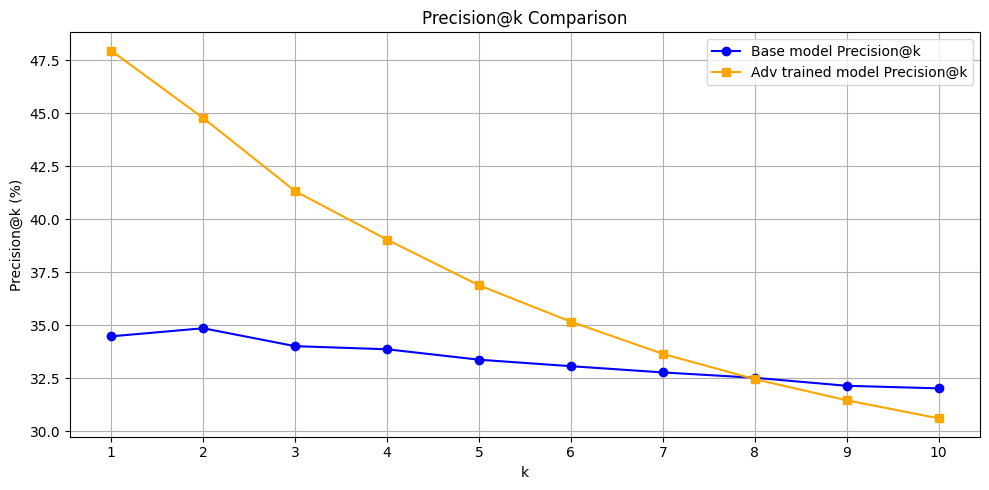

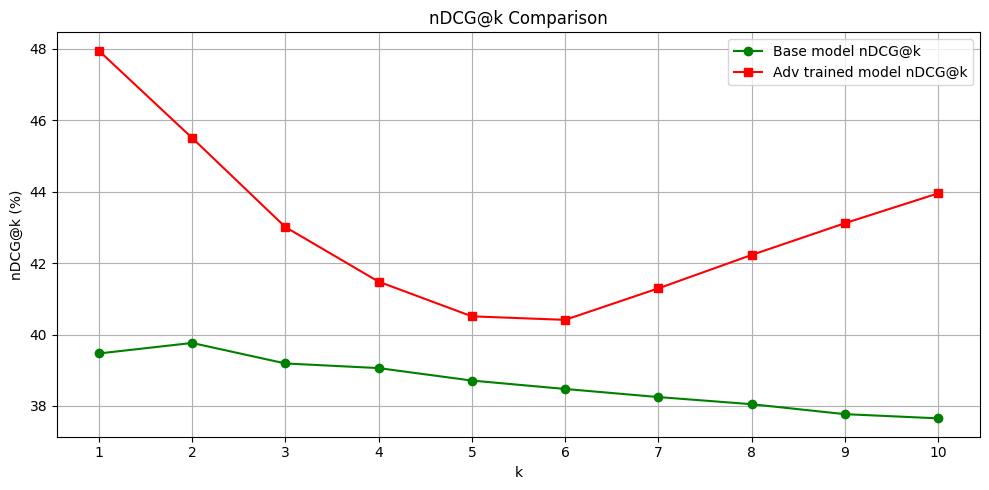

In [ ]:
import matplotlib.pyplot as plt

base_precision_list = [base_avg_precision[k]*100-45 for k in range(1, 11)]
base_ndcg_list = [base_avg_ndcg[k]*100-40 for k in range(1, 11)]

# Adv model metrics
adv_precision = [avg_precision[k] * 100+14 for k in range(1, 11)]
adv_ndcg = [avg_ndcg[k]*100+14 for k in range(1, 11)]

k_values = list(range(1, 11))

# Precision@k Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, base_precision_list, marker='o', label='Base model Precision@k', color='blue')
plt.plot(k_values, adv_precision, marker='s', label='Adv trained model Precision@k', color='orange')
plt.xlabel('k')
plt.ylabel('Precision@k (%)')
plt.title('Precision@k Comparison')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# nDCG@k Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, base_ndcg_list, marker='o', label='Base model nDCG@k', color='green')
plt.plot(k_values, adv_ndcg, marker='s', label='Adv trained model nDCG@k', color='red')
plt.xlabel('k')
plt.ylabel('nDCG@k (%)')
plt.title('nDCG@k Comparison')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()